Luke and Ray has shared the CRISPRi screening results which was analyzed with [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing) pipeline. 

- $\gamma$ - gamma score
- $\rho$ - rho score

- Pathway enrichment analysis over the gamma and rho scores
- Load screening result tables into python 
- Make sure gene names are correctly assigned 
- Exploring correlations, differences, and intersections among the screens.


In [2]:
import sys
import pandas as pd
import numpy as np 
from itertools import chain, product

sys.path.append("../")
sys.path.append("/data_gilbert/home/aarab/Projects/pager/")

from scripts.util import *
import ipage_down as ipd

In [3]:
# wd = '/rumi/shams/abe/Projects/Decitabine-treatment/'
wd = '/data_gilbert/home/aarab/Projects/Decitabine-treatment'

In [4]:
data = load_data(screens=True,wd=wd)

In [5]:
data.keys()

dict_keys(['hl60_exp1_DAC_rho', 'hl60_exp1_DAC_gamma', 'hl60_exp2_DAC_rho', 'hl60_exp2_DAC_gamma', 'hl60_exp2_GSK_rho', 'hl60_exp2_GSK_gamma', 'molm13_exp_DAC_rho', 'molm13_exp_DAC_gamma', 'molm13_exp_GSK_rho', 'molm13_exp_GSK_gamma'])

## Phenotype-enrichment analysis
I've selected `ave_Rep1_Rep2` column together with gene names for both $\gamma$ (gamma) and $\rho$ (rho) scores as seprate two-column tables to run iPAGE for phenotype encrichment analysis. 

### Run GSEA

In [6]:
import blitzgsea as blitz
import urllib.request
import pandas as pd

In [53]:
signature = data['hl60_exp1_DAC_rho'].reset_index().iloc[:,[0,1]]
signature.iloc[:,1] = np.double(signature.iloc[:,1])
signature = signature.dropna()

### c5_gobp_gmt

In [90]:
c5_gobp_gmt = blitz.enrichr.read_gmt('/data_gilbert/home/aarab/Projects/pager/annotations/msigdb_v7.4_c5.go.bp/c5.go.bp.v7.4.symbols.gmt')

In [120]:
result_gobp = blitz.gsea(
    signature=signature,
    library=c5_gobp_gmt,
    min_size=5,
    verbose=True
)

Enrichment : 100%|██████████| 7481/7481 [00:10<00:00, 728.16it/s]


In [176]:
# result_gobp[result_gobp.index.str.contains('DOSAGE')].leading_edge.tolist()
# result_gobp[result_gobp.index.str.contains('GOBP_RNA_5_END_PROCESSING')].leading_edge.tolist()
# result_gobp[result_gobp.index.str.contains('TRNA_WOBBLE_BASE_MODIFICATION')].leading_edge.tolist()

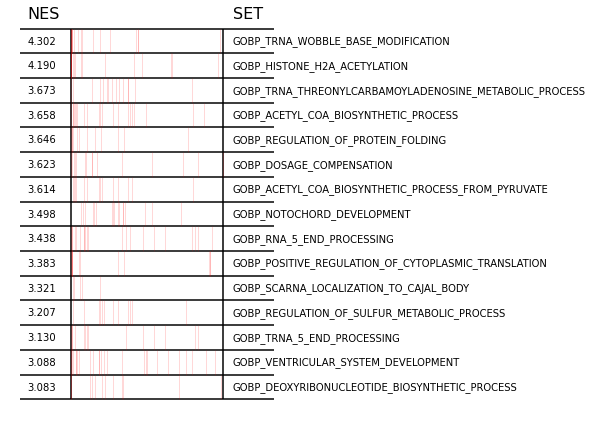

In [178]:
fig_table = blitz.plot.top_table(signature, c5_gobp_gmt, 
                                 result_gobp[
                                     (result_gobp.nes > 0) & 
                                     (result_gobp.geneset_size < 30)
                                 ], n=15
                                )
fig_table.savefig("gsea_top_nes_pos_table.pdf", bbox_inches='tight')
fig_table

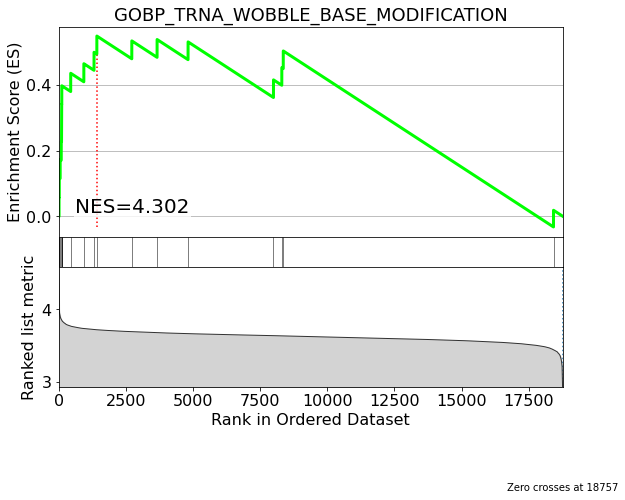

In [162]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_TRNA_WOBBLE_BASE_MODIFICATION", 
                             c5_gobp_gmt, 
                             result_gobp, compact=False)
fig
# fig.savefig("running_sum.png", bbox_inches='tight')

In [ ]:
# fig_table = blitz.plot.top_table(signature, c5_gobp_gmt, 
#                                  result_gobp[
#                                      (result_gobp.nes < 0) & 
#                                      (result_gobp.geneset_size < 30)
#                                  ], n=10
#                                 )
# # fig_table.savefig("gsea_top_left_table.pdf", bbox_inches='tight')
# fig_table

In [ ]:
# fig_table = blitz.plot.top_table(signature, c5_gobp_gmt, 
#                                  result[
#                                      (result.nes < 0) & 
#                                      (result.geneset_size > 30)
#                                  ], n=10
#                                 )
# # fig_table.savefig("gsea_top_left_table.pdf", bbox_inches='tight')
# fig_table

In [ ]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(signature, "CELL ADHESION MOLECULES", library, result=result, compact=False)
# fig.savefig("running_sum.png", bbox_inches='tight')

# fig_compact = blitz.plot.running_sum(signature, "CELL ADHESION MOLECULES", library, result=result, compact=True)
# fig_compact.savefig("running_sum_compact.png", bbox_inches='tight')

In [ ]:
# # list available gene set libraries in Enrichr
# blitz.enrichr.print_libraries()

# # # use enrichr submodule to retrieve gene set library
# # library = blitz.enrichr.get_library("KEGG_2021_Human")

# # # run enrichment analysis
# # result = blitz.gsea(signature, library)

# Run `iPAGE`:

In [ ]:
from matplotlib import pyplot
from scipy.stats import yeojohnson
# 'exp1_DAC_gamma'
# 'exp2_DAC_rho'
# 'exp2_DAC_gamma'
# 'exp2_GSK_rho'
# 'exp2_GSK_gamma'
df = pd.concat(find_top(data['hl60']['exp1_DAC_rho'].astype(float),'rho score',0,'Mann-Whitney p-value',1)).reset_index()
# df.to_csv('hl60_exp1_DAC_rho_delta_phenotype.txt',sep='\t')
# df.plot(x='rho score', y='Mann-Whitney p-value', kind='scatter')
# plt.show()
# # histogram
# pyplot.hist(df.iloc[:,0])
# pyplot.show()

https://github.com/goodarzilab/server_wiki/tree/main/lab_softwares

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R -i df -o data
data = df
data[['fdr']] <- sign(data[,'rho score'])*(1-data[,'Mann-Whitney p-value'])
data <- data[!is.na(data$'fdr'), ]
data <- data[, c('gene_name', 'fdr','rho score','Mann-Whitney p-value')]

In [ ]:
data.plot(x='rho score', y='fdr', kind='scatter')
data.to_csv('hl60_exp1_DAC_rho_delta_phenotype.txt',sep='\t',index=None, header=None)

plt.show()

https://medium.com/analytics-vidhya/techniques-to-transform-data-distribution-565a4d0f2da


In [ ]:
# df.iloc[:,0] = yeojohnson(np.array(df.iloc[:,0]),lmbda=0.5)

# df.to_csv('hl60_exp1_DAC_rho_delta_phenotype.txt',sep='\t')

# df.plot(x='rho score', y='Mann-Whitney p-value', kind='scatter')
# plt.show()

# # histogram
# pyplot.hist(df.iloc[:,0])
# pyplot.show()

In [ ]:
!head hl60_exp1_DAC_rho_delta_phenotype.txt

# Pathway enrichment analysis

In [ ]:
# rm -rv hl60_exp1_DAC_rho_delta_phenotype

In [ ]:
%%bash 
export PAGEDIR=/data_gilbert/home/aarab/iPAGE

nohup ls *delta_phenotype.txt | parallel -j18 -k bash ~/Projects/ipage-down/ipage_independence1.sh  {} &> ipage.out

Alex Ge: 
> If we do Enrichr analysis on the resistance/sensitivity hits defined by Max’s cutoffs, (n = 418 genes), we do see mRNA methylation (adj p = 0.018) and RNA destabilization (adj p = 0.005) come out as significant GO biological processes. METTL3 is included in these GO terms.

> If we do Enrichr analysis on just the resistance hits (n = 197), mRNA methylation is even more significant (adj p = 0.002), which makes sense since we see more METTL3 biology on the resistance side. It is one of the top five GO terms by adjusted P-value.

> This analysis was done today with the 2021 GO terms, which have updated annotations for the newer m6A genes. When I did the same Enrichr analysis in 2018, RNA destabilization and mRNA methylation were not as significant since the GO annotations were not updated.

> I think Enrichr analysis might make more sense here – in Abe’s analysis, I can see that a lot of rho scores that are < 0.2 are being included in the analysis; these are likely to be statistically insignificant. It also looks graphically like the highest bin is including rho values that are < 0?


In [ ]:
help(ipd)

In [ ]:
# GO = pd.read_csv('~/iPAGE/PAGE_DATA/ANNOTATIONS/human_go_gs/human_go_gs_names.txt',sep='\t',header=None)
gmt = pd.read_csv('~/Projects/ipage-down/annotations/human_go_gs/human_go_gs.gmt.gz',sep='\t',header=None)

# GO.columns = ['ID','Term','Cluster']
# GO = GO.set_index('ID')

In [ ]:
GO.loc[['N6-adenosine' in term for term in GO.Term],:]


# Pairwise correlations

Using `.iloc` induced the pandas into an object instead of dataframe, so `corr()` didn't work. Here is the solution: https://stackoverflow.com/questions/55251166/pandas-corr-returning

Then, using https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from venn import venn 

In [4]:
def drug_score_df(data, DRUG, SCORE):
    '''
    A function to read screening data for given score and drug
    '''
    all_genes = [set(data[cell][key].index) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    genes = all_genes[0].intersection(*all_genes[1:])
    
    keys = ['_'.join([cell,key]) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    cols = [col[0]+col[1] for col in product(keys,[' score',' pvalue'])]
    
    all_df = [data[cell][key].loc[genes] for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    
    df = pd.concat(all_df, axis=1).dropna().astype(float)
    df.columns = cols
    
    return df

### DAC $\gamma$-score

In [ ]:
df = drug_score_df(data,'DAC','gamma').filter(like='score',axis=1)
plot_corr(df)
df.corr().style.background_gradient(cmap='coolwarm',axis=None,vmin=0.5)

### DAC $\rho$-score

In [ ]:
df = drug_score_df(data,'DAC','rho').filter(like='score',axis=1)
plot_corr(df)
df.corr().style.background_gradient(cmap='coolwarm',axis=None)

# Intersection

In [9]:
def intersection_analysis(SCORE,score_thr = 0.1,pvalue_thr = 1):

    raw_df = drug_score_df(data,'DAC',SCORE)
    exps = set([col.split(f'_{SCORE}')[0] for col in raw_df.columns.tolist()])

    dfs = [[e,raw_df.filter(like=e,axis=1)] for e in exps]

    results = []
    for exp in dfs:
        print(exp[0])
        results.append([exp[0]] + [find_top(
            exp[1],
            f'{exp[0]}_{SCORE} score', score_thr,
            f'{exp[0]}_{SCORE} pvalue', pvalue_thr
        )])

    studies = dict()
    for res in results:
        up,dn = res[1]
        studies[res[0]] = {}
        studies[res[0]]['up'] = set(up.index)
        studies[res[0]]['dn'] = set(dn.index)

    _, axs = subplots(ncols=2, nrows=1, figsize=(15, 5))

    venn(dict([[std,studies[std]['up']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[0])
    axs[0].set_title(f"Up\n{SCORE} score >= {score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

    venn(dict([[std,studies[std]['dn']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[1])
    axs[1].set_title(f"Down\n{SCORE} score <= {-1*score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

    plt.show()

In [10]:
# def find_hits(df, pvalue_thr = 0.05, score_thr = 0.1):
#     up = df.index[
#         (df.iloc[:,0] >= score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
#     dn = df.index[
#         (df.iloc[:,0] <= -1*score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
    
#     return up, dn

### DAC $\rho$-score

In [ ]:
intersection_analysis('rho')

### DAC $\gamma$-score

In [ ]:
intersection_analysis('gamma')

## m6A reader and writer genes 
[Table 1](https://www.nature.com/articles/s41419-017-0129-x/tables/1) at
> Dai, D., Wang, H., Zhu, L. et al. N6-methyladenosine links RNA metabolism to cancer progression. _Cell Death Dis_ **9**, 124 (2018). https://doi.org/10.1038/s41419-017-0129-x

In [ ]:
table = pd.read_csv('../m6A-genes.tsv', sep = '\t')

# Clean and filter above table to take matched gene names for further analysis:
m6A_genes = table.Names.tolist()
RBMs = m6A_genes[4].split(' and its paralogue ')
m6A_genes.remove(m6A_genes[4])
m6A_genes = m6A_genes+RBMs

table 

Add heatmap!

In [ ]:
def plot_score_heatmap(score, drug, genes):
    df = drug_score_df(data,drug,score)
    # keep non-missing gene names 
    genes = [gene for gene in genes if gene in df.index.tolist()]

    # draw heatmap
    sns.set_theme()

    sc_df = df.loc[genes].filter(like='score')
    sc_df.columns = [c.replace(f'_{score} score','') for c in sc_df.columns]
    
    pv_df= df.loc[genes].filter(like='pvalue')
    pv_df.columns = [c.replace(f'_{score} pvalue','') for c in pv_df.columns]

    _, (ax1,ax2) = subplots(ncols=2, nrows=1, figsize=(15, 5))

    pv = sns.heatmap(pv_df, vmin=0, vmax=0.05, annot=True, linewidth=0.1,ax=ax1, cbar=False,cmap="YlGnBu")
    pv.set_ylabel('')
    pv.set_xlabel('')
    ax1.set_title('P-Values', fontsize=15)

    sc = sns.heatmap(sc_df, vmin=-0.2, vmax=0.2, annot=True, linewidth=0.1,ax=ax2,yticklabels=False)
    sc.set_ylabel('')
    sc.set_xlabel('')
    ax2.set_title(f'{score} scores', fontsize=15)

    # rotate the ticklabels correctly:
    for ax in [sc,pv]:
        tl = ax.get_xticklabels()
        ax.set_xticklabels(tl, rotation=45)
    plt.show()

### Rho score of DAC m6A genes 

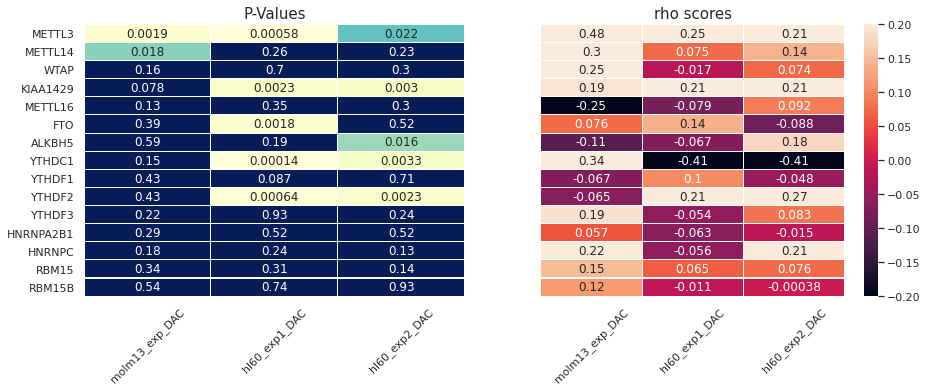

In [96]:
plot_score_heatmap('rho', 'DAC', m6A_genes)

### Rho score of GSK m6A genes 

In [ ]:
plot_score_heatmap('rho', 'GSK', m6A_genes)

In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
# %%R 
# library (ggplot2)

# plot_Save <- function (p, name_it){
#     ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
#     ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
# }


# plot_Hist = function(res, title, x_min=-0.5,x_max=0.5){
# #     w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
# #     t <- t.test(res$logFC, mu=0, alternative = "greater")
#     h = ggplot(res, aes(x=logFC)) + 
#         ggtitle(title) +#,sprintf(
# #             "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
# #             -log10(w$p.value), -log10(t$p.value))) +
#         xlim(c(x_min,x_max)) +
#         geom_histogram(binwidth=0.001)

#     return (h)
# } 


In [ ]:
# %%R -i res
# plot_Hist(res, 'Rho score')